# Track Active Particles - a Boiler plate
##### Written by Matan Yah Ben Zion 20191130

## A generic code to locate and track active particles from microscopy images
### Based on trackpy walkthrough

# Input: Tiff Stack
# Output: CSV locs and links and png report of MSD

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp


import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')



## Step 1: Read the Data

In [2]:

folderName = '/Users/matan/Documents/data/charybdis/20190111singleSwimerPowerRamp/powerRampSingleSwimmerMagneticDC_xy_2A'

#fileName = 'nC12H3_2A_DC_P0.80W_ObjX40_1024X768_BIN2X2_10fps_0064.tif'
fileName = 'nC12H3_2A_DC_P1.50W_ObjX40_1024X768_BIN2X2_10fps_0080.tif'
#fileName = 'nC12H3_2A_DC_P2.00W_ObjX40_1024X768_BIN2X2_10fps_0099.tif'
fullPath = folderName + '/' +fileName

frames = pims.TiffStack(fullPath, as_grey=True)

framesPerSecond = 10. #fps
pixelSize = 0.163 # [um/pixel]

Frame([[54, 51, 51, ..., 48, 47, 44],
       [54, 51, 51, ..., 48, 47, 44],
       [47, 48, 47, ..., 48, 42, 45],
       ...,
       [47, 48, 48, ..., 43, 44, 44],
       [47, 48, 48, ..., 43, 44, 44],
       [39, 43, 48, ..., 43, 45, 44]], dtype=uint8)
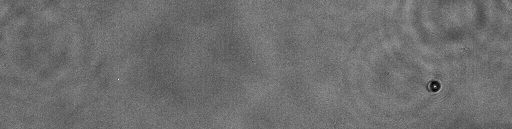

In [3]:
frames[0]

## Step 2: Locate Features

Start with just the first frame. Estimate the size of the features (in pixels). The size must be an odd integer, and it is better to err on the large side, as we'll see below. I estimate 11 pixels.

In [4]:
# Characterisitc appearance of a particle (size, mass, eccentricity) 
minMass = 5000
diameter = 25
frameNum = 300
invert = True
maxECC = 0.2

# Frames to analyze
frameRange = range(0,len(frames))

minTrajLength = 80 

In [5]:
f = tp.locate(frames[frameNum], diameter = diameter, minmass = minMass, invert=invert)

In [6]:
f.head() # shows the first few rows of data

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
107,116.903391,227.081578,6401.019401,8.157673,0.053516,28.965945,101322.0,0.04751,300


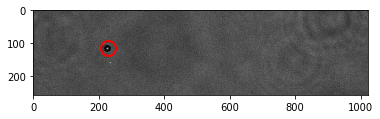

In [7]:
tp.annotate(f, frames[frameNum]);

### Refine parameters to elminate spurious features
Many of these circles are clearly wrong; they are fleeting peaks in brightness that aren't actually particles. There are many ways to distinguish real particles from spurrious ones. The most important way is to look at total brightness ("mass").

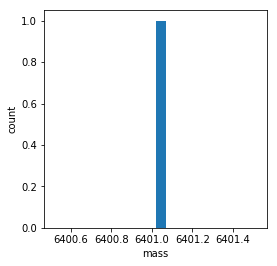

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');

## Track a batch of frames 
### 100 take about less than half a minute to complete)
#### see frameRange var in the initialization

In [9]:
f = tp.batch(frames[frameRange], diameter, minmass=minMass, invert=invert);

Frame 429: 0 features


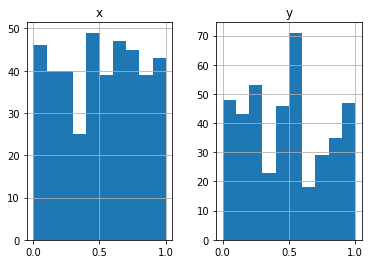

In [11]:
tp.subpx_bias(f);

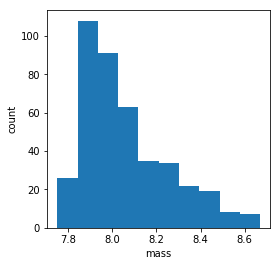

In [12]:
fig, ax = plt.subplots(figsize=(4,4))
ax.hist(f['size'], bins=10)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count');



## Step 3: Link features into particle trajectories


In [13]:
linkingMemory = 10
searchRange = 20
t = tp.link_df(f, search_range = searchRange, memory=linkingMemory)

Frame 414: 1 trajectories present.


The result is the features DataFrame ``f`` with an additional column, ``particle``, identifying each feature with a label.

In [14]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,171.935563,869.230161,5764.879872,7.997325,0.149449,28.445315,100543.0,NaN,0,0
1,174.466122,870.304719,6144.214079,8.028579,0.129612,29.130369,100741.0,NaN,1,0
2,174.479416,870.247999,6187.633612,8.020655,0.123454,29.432494,100670.0,NaN,2,0
3,175.046477,870.845126,6038.231924,8.011603,0.116606,28.891062,100490.0,0.055677,3,0
4,176.358574,869.896077,6151.361716,7.994785,0.119734,29.472723,100555.0,NaN,4,0


### Filter spurious trajectories.

We have more filtering to do. Empheremeral trajectories -- seen only for a few frames -- are usually spurious and never useful. The convenience function ``filter_stubs`` keeps only trajectories that last for a given number of frames.

In [15]:
t1 = tp.filter_stubs(t, minTrajLength)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 1
After: 1


We can also filter trajectories by their appearance. At this stage, with trajectories linked, we can look at a feature's "average appearance" throughout its trajectory, giving a more accurate picture.

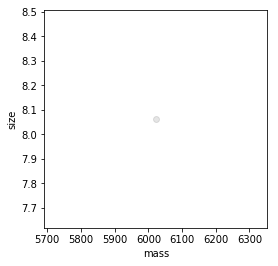

In [16]:
plt.figure(figsize=(4,4))
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

The particles with especially low mass or especially large size are probably out of focus or aggregated, respectively. It is best to experiment by trial and error, filtering out regions of mass-size space and looking at the results using ``tp.annotate`` and ``tp.circle``. In the end, we need to separate the good particles from the spurious ones, and it doesn't matter how we get it done.

In [17]:
t2 = t1[((t1['mass'] > minMass) & (t1['size'] < diameter/1.) &
         (t1['ecc'] < maxECC))]

# Save locations and tracks

In [18]:
f.to_csv(folderName+'/'+fileName+'_loc.csv')
t2.to_csv(folderName+'/'+fileName+'_link.csv')

# Step 4: Analyze trajectories
## Ensemble Mean Squared Displacement
### Choose maximumg lag time
#### A a stable result has the greatest lag with at least 3 samples

In [19]:
#maxLagTime = np.int(len(frameRange)/3)
maxLagTime = len(frameRange)

In [25]:
em = tp.emsd(t2, pixelSize, framesPerSecond,max_lagtime=maxLagTime)
powerLaw=tp.utils.fit_powerlaw(em,plot=False)  # performs linear best fit in log space, plots
n,A = str(np.round(powerLaw['n'].values[0],2)),str(np.round(powerLaw['A'].values[0],2))

midFrame = frameRange[np.int(len(frameRange)/2)]
frameToAnnotate = midFrame

### Plot and save an MSD report 
#### Includes MSD vs time, powerlaw fit and inset with trajs on image,

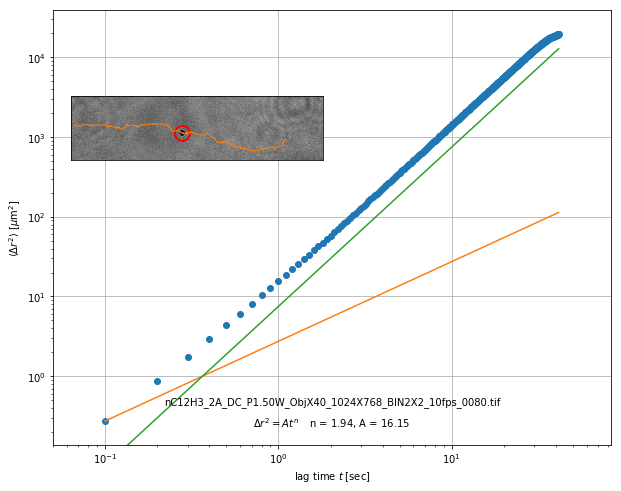

In [27]:
fig, ax = plt.subplots(figsize=(10,8))

ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel=r'lag time $t\;\left[ \rm{sec} \right]$')

refX = np.linspace(em.index.min(),em.index.max(),10)
linY = em.values.min()/em.index.min()*refX
parY = linY**2
ax.plot(refX,linY,refX,parY)

ax.set(xlim=(0.5*em.index.min(), em.index.max()*2),ylim=(0.5*em.min(),em.max()*2));
ax.grid()


axInst = plt.axes([0.15,0.5,0.35,0.35])
tp.annotate(t2[t2['frame'] == frameToAnnotate], frames[frameToAnnotate],ax=axInst);
tp.plot_traj(t1,ax=axInst);
axInst.set_xticks([])
axInst.set_yticks([])
axInst.set_xlabel('')
axInst.set_ylabel('')

ax.text(0.5,0.1, fileName,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.5,0.05, r'$\Delta r^2 = A t^n\;\;\;$ ' 'n = ' + n+ ', A = ' + A,horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
fig.savefig(folderName+'/'+fileName+'trackReport.png')